In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from torch.utils.data.dataset import Dataset
%matplotlib inline
import torchbnn as bnn
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, classification_report
from sklearn.metrics import roc_auc_score
# Set Constants
RANDOM_STATE = 42
from sklearn.metrics import recall_score, auc, roc_curve
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
df = pd.read_excel('processminer-rare-event-mts.xlsx', index_col='time')
print(df.shape)
df.head()

(18398, 62)


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
time,,,,,,,,,,,,,,,,,,,,,
1999-05-01 00:00:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1999-05-01 00:02:00,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
1999-05-01 00:04:00,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
1999-05-01 00:06:00,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
1999-05-01 00:08:00,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18398 entries, 1999-05-01 00:00:00 to 1999-05-29 00:06:00
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       18398 non-null  int64  
 1   x1      18398 non-null  float64
 2   x2      18398 non-null  float64
 3   x3      18398 non-null  float64
 4   x4      18398 non-null  float64
 5   x5      18398 non-null  float64
 6   x6      18398 non-null  float64
 7   x7      18398 non-null  float64
 8   x8      18398 non-null  float64
 9   x9      18398 non-null  float64
 10  x10     18398 non-null  float64
 11  x11     18398 non-null  float64
 12  x12     18398 non-null  float64
 13  x13     18398 non-null  float64
 14  x14     18398 non-null  float64
 15  x15     18398 non-null  float64
 16  x16     18398 non-null  float64
 17  x17     18398 non-null  float64
 18  x18     18398 non-null  float64
 19  x19     18398 non-null  float64
 20  x20     18398 non-null  float64
 21  

In [5]:
# Check for duplicate rows
duplicated_rows_check = df.duplicated()  #true/false for each row
duplicate_rows = df[duplicated_rows_check]
duplicate_rows.shape

(0, 62)

### Variance Inflation Factor (VIF) for correlated features

In [6]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

In [7]:
vif_data.head(60)

,feature,VIF
0,y,1.243914
1,x1,3.724090
2,x2,2.795225
3,x3,3.910850
4,x4,7.538123
5,x5,3.489879
6,x6,193.303802
7,x7,2.891010
8,x8,6.933053
9,x9,3.113818


In [8]:
# Dropimh high variance columns
vif2_data = pd.DataFrame()
df = df.drop(columns=['x6', 'x59','x57','x45','x31','x34','x28','x25','x61'])
vif2_data["feature"] = df.columns
vif2_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

vif2_data

,feature,VIF
0,y,1.118414
1,x1,3.349290
2,x2,2.398120
3,x3,3.768797
4,x4,3.663891
5,x5,3.407622
6,x7,2.873200
7,x8,6.734787
8,x9,3.086469
9,x10,3.005212


In [9]:
data_path = os.path.join('data', 'cleaned.csv')
df.to_csv(data_path)

In [21]:
df.y.value_counts()

0    18274
1      124
Name: y, dtype: int64

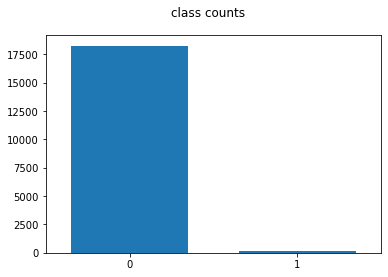

In [11]:
# Check for balance in prediction class variable
bins = np.arange(0, 1 + 1.5) - 0.5

fig, ax = plt.subplots()
_ = ax.hist(df['y'], bins, rwidth = 0.7)
ax.set_xticks(bins + 0.5)
ax.set_xlim(-0.5, 1.5)
fig.suptitle('class counts')

fig.savefig(os.path.join('images', 'EDA_TargetCounts.png'))

In [12]:
x = df.iloc[:,1:]
Y = df.y.astype(int)

In [13]:
sd = StandardScaler()
df_new = pd.DataFrame(sd.fit_transform(x.values), columns=x.columns, index=x.index)


In [14]:
x = np.array(df_new)
Y = Y.to_numpy()

In [15]:
x, y = torch.from_numpy(x).float(), torch.from_numpy(Y).long()
x.shape, y.shape

(torch.Size([18398, 52]), torch.Size([18398]))

## Basic bayesian neural network

In [16]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.2, in_features=52, out_features=900),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.2, in_features=900, out_features=2),
)

In [17]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [18]:
kl_weight = 0.2
for step in range(4000):
    pre = model(x)
    ce = ce_loss(pre, y)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))


- Accuracy: 99.494510 %
- CE : 0.02, KL : 0.18


In [19]:
np_arr = predicted.cpu().detach().numpy()
unique, counts = np.unique(np_arr, return_counts=True)
dict(zip(unique, counts))


{0: 18249, 1: 149}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18274
           1       0.60      0.73      0.66       124

    accuracy                           0.99     18398
   macro avg       0.80      0.86      0.83     18398
weighted avg       1.00      0.99      1.00     18398

0.8612889103856352


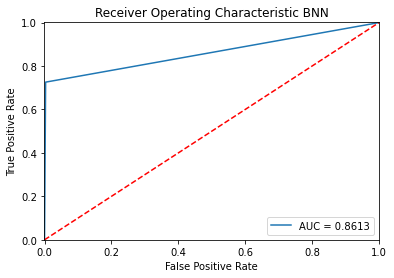

0.8612889103856352

In [20]:
## Score
print(classification_report(y,np_arr))
score_fpr, score_tpr, _ = roc_curve(y, predicted)
score_roc_auc = roc_auc_score(y, predicted)
print(score_roc_auc)
plt.title('Receiver Operating Characteristic BNN')
plt.plot(score_fpr, score_tpr, label='AUC = %0.4f'% score_roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();
score_roc_auc

## Baseline model

### Lstm autoencoder

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, Sequential
from keras.models import Model
# from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)


from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","anomaly"]
from IPython.display import display, Math

In [24]:
# Clean data set
import time
input_X = df.loc[:, df.columns != 'y'].values  # converts the df to a numpy array
input_y = df['y'].values

n_features = input_X.shape[1]  # number of features

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 ))) 



First instance of y = 1 in the original data


,y,x1,x2,x3,x4,x5,x7,x8,x9,x10,...,x49,x50,x51,x52,x53,x54,x55,x56,x58,x60
time,,,,,,,,,,,,,,,,,,,,,
1999-05-01 08:28:00,0,0.975947,-3.913736,-1.304682,0.561987,0.004034,0.000732,-0.051043,-0.040129,0.001791,...,-50.368248,9.353749,29.984624,11.257736,-0.752385,-5.015081,-61.783749,71.917352,0.031310,0.007743
1999-05-01 08:30:00,0,0.997107,-3.865720,-1.133779,0.377295,-0.219126,0.000732,-0.061114,-0.040129,0.001791,...,-49.591667,9.345204,29.984624,11.262375,-0.752385,-5.015176,-70.151791,73.876977,0.030776,0.007727
1999-05-01 08:32:00,0,1.016235,-4.058394,-1.097158,2.327307,-0.442286,0.000732,-0.061114,-0.040129,0.001791,...,-48.815056,9.336659,29.984624,11.267013,-0.752385,-5.015270,-60.884701,72.188928,0.031186,0.007711
1999-05-01 08:34:00,0,1.005602,-3.876199,-1.074373,0.844397,-0.553050,0.000732,-0.061114,-0.030057,0.001791,...,-48.038444,9.328114,29.984624,11.271652,-0.752385,-5.015364,-69.553891,70.500879,0.031596,0.007695
1999-05-01 08:36:00,0,0.933933,-3.868467,-1.249954,2.875311,-0.500941,0.000732,-0.061114,-0.030057,0.001791,...,-41.112633,9.319569,29.984624,11.276291,-0.752385,-5.015458,-75.298153,68.812829,0.032007,0.007679
1999-05-01 08:38:00,1,0.892311,-13.332664,-10.006578,2.855933,-0.448832,0.000732,-0.061114,-0.030057,0.001791,...,-43.210716,9.311024,29.984624,11.280929,-0.752385,-5.015553,-75.896664,69.585016,0.032223,0.007663


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.997107,-3.865720,-1.133779,0.377295,-0.219126,0.000732,-0.061114,-0.040129,0.001791,0.897280,...,-49.591667,9.345204,29.984624,11.262375,-0.752385,-5.015176,-70.151791,73.876977,0.030776,0.007727
1,1.016235,-4.058394,-1.097158,2.327307,-0.442286,0.000732,-0.061114,-0.040129,0.001791,1.079882,...,-48.815056,9.336659,29.984624,11.267013,-0.752385,-5.015270,-60.884701,72.188928,0.031186,0.007711
2,1.005602,-3.876199,-1.074373,0.844397,-0.553050,0.000732,-0.061114,-0.030057,0.001791,0.798808,...,-48.038444,9.328114,29.984624,11.271652,-0.752385,-5.015364,-69.553891,70.500879,0.031596,0.007695
3,0.933933,-3.868467,-1.249954,2.875311,-0.500941,0.000732,-0.061114,-0.030057,0.001791,0.894024,...,-41.112633,9.319569,29.984624,11.276291,-0.752385,-5.015458,-75.298153,68.812829,0.032007,0.007679
4,0.892311,-13.332664,-10.006578,2.855933,-0.448832,0.000732,-0.061114,-0.030057,0.001791,0.754229,...,-43.210716,9.311024,29.984624,11.280929,-0.752385,-5.015553,-75.896664,69.585016,0.032223,0.007663


In [25]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [26]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]
X_train_y0.shape

(11692, 5, 1, 52)

####  Reshaping the data

In [27]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [28]:
def flatten(X):
  
   
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):

    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [29]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [30]:
'''
Test: Check if the scaling is correct.

The test succeeds if all the column means 
and variances are 0 and 1, respectively, after
flattening.
'''
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [-0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0. -0.  0.  0. -0. -0. -0.
  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0. -0. -0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [31]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 32)             10880     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 16)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 52)             1716      
Total params: 24,116
Trainable params: 24,116
Non-trainable params: 0
____________________________________________________

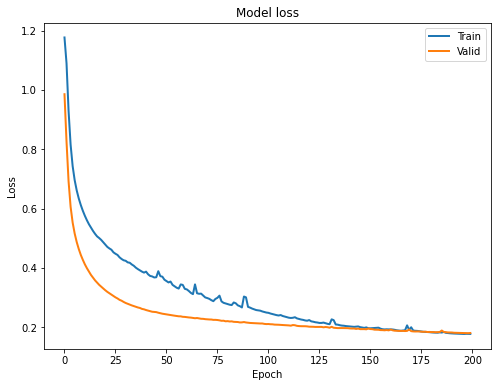

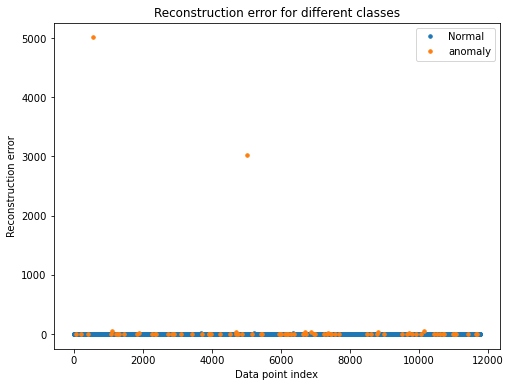

In [32]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59

epochs = 200
batch = 64
lr = 0.0001
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "anomaly" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

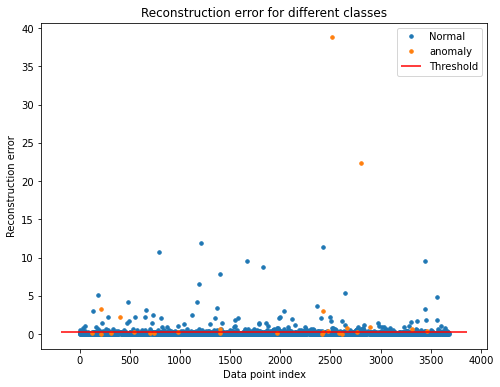

In [38]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "anomaly" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      3654
           1       0.04      0.48      0.08        25

    accuracy                           0.93      3679
   macro avg       0.52      0.70      0.52      3679
weighted avg       0.99      0.93      0.96      3679



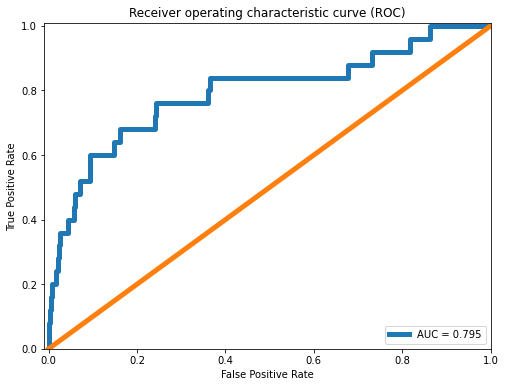

In [39]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
print(classification_report(error_df.True_class, pred_y))
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Autoencoder

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 52)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1696      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_10 (Dense)             (None, 52)                1716      
Total params: 4,756
Trainable params: 4,756
Non-trainable params: 0
_________________________________________________________

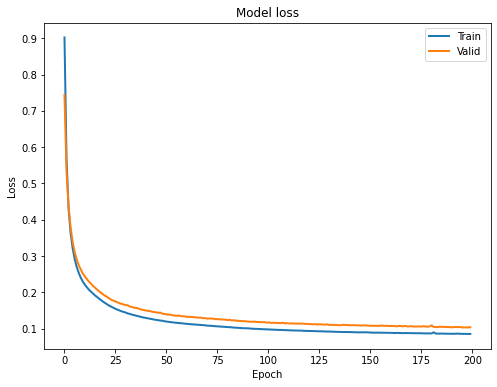

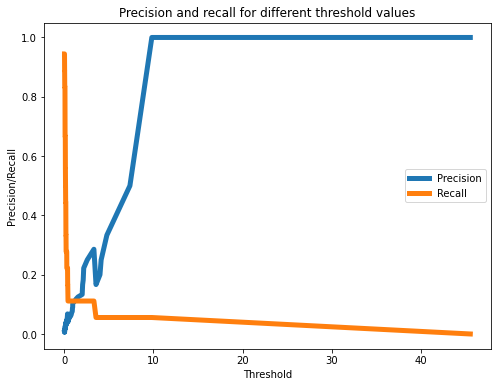

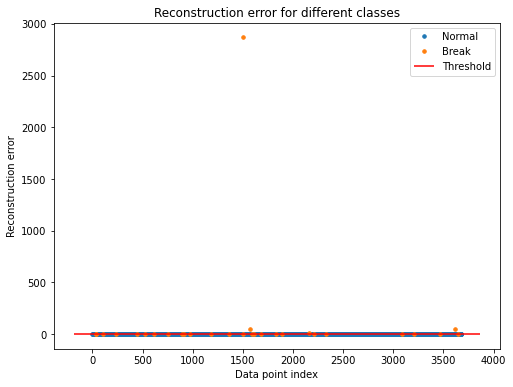

In [40]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

nb_epoch = 200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()

threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2926
           1       0.06      0.17      0.09        18

    accuracy                           0.98      2944
   macro avg       0.53      0.58      0.54      2944
weighted avg       0.99      0.98      0.98      2944



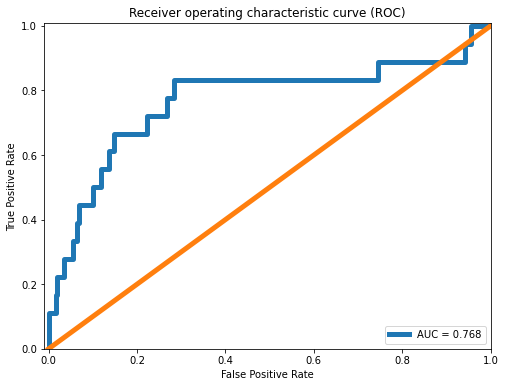

In [41]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
predictions = pd.DataFrame({'true': error_df.True_class,
                           'predicted': pred_y})
print(classification_report(error_df.True_class, pred_y))
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()